nodes:  25 links  57


Population=75:   0%|          | 0/120 [00:00<?, ?it/s]

Population=150:   0%|          | 0/120 [00:00<?, ?it/s]

Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

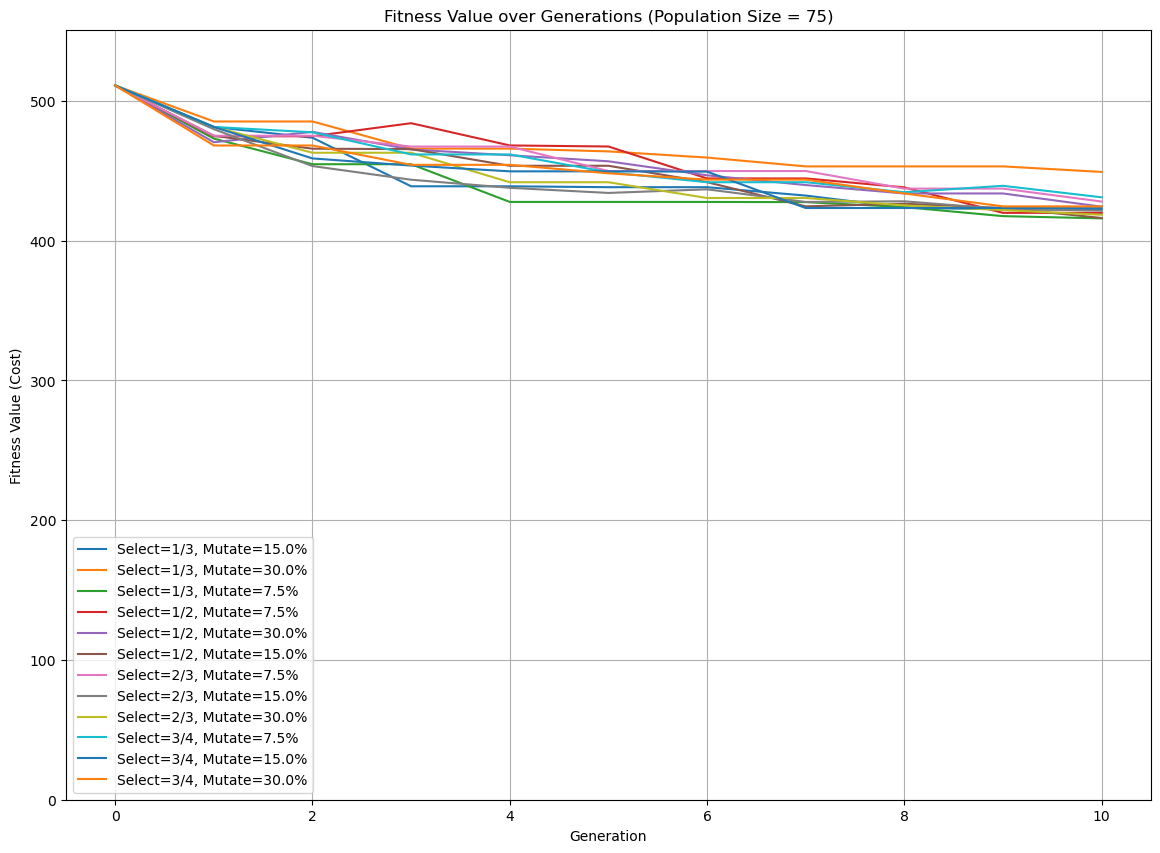

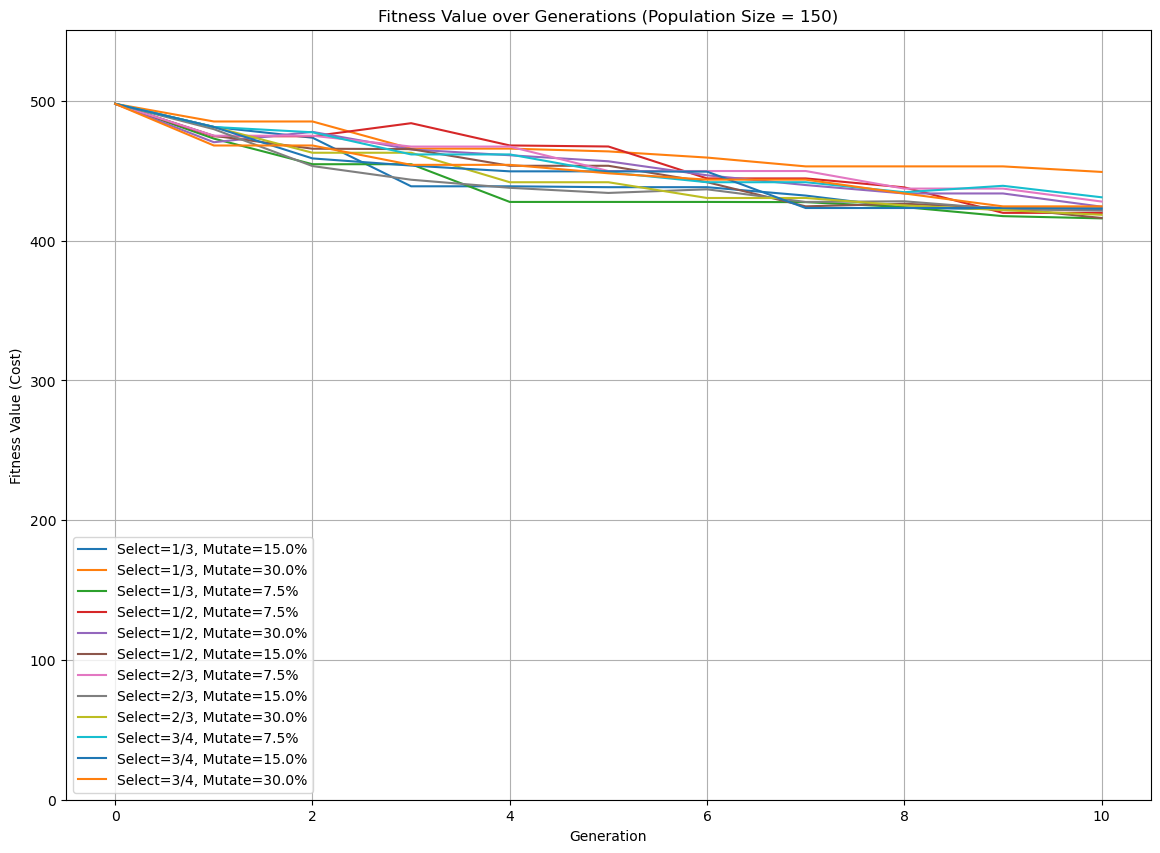

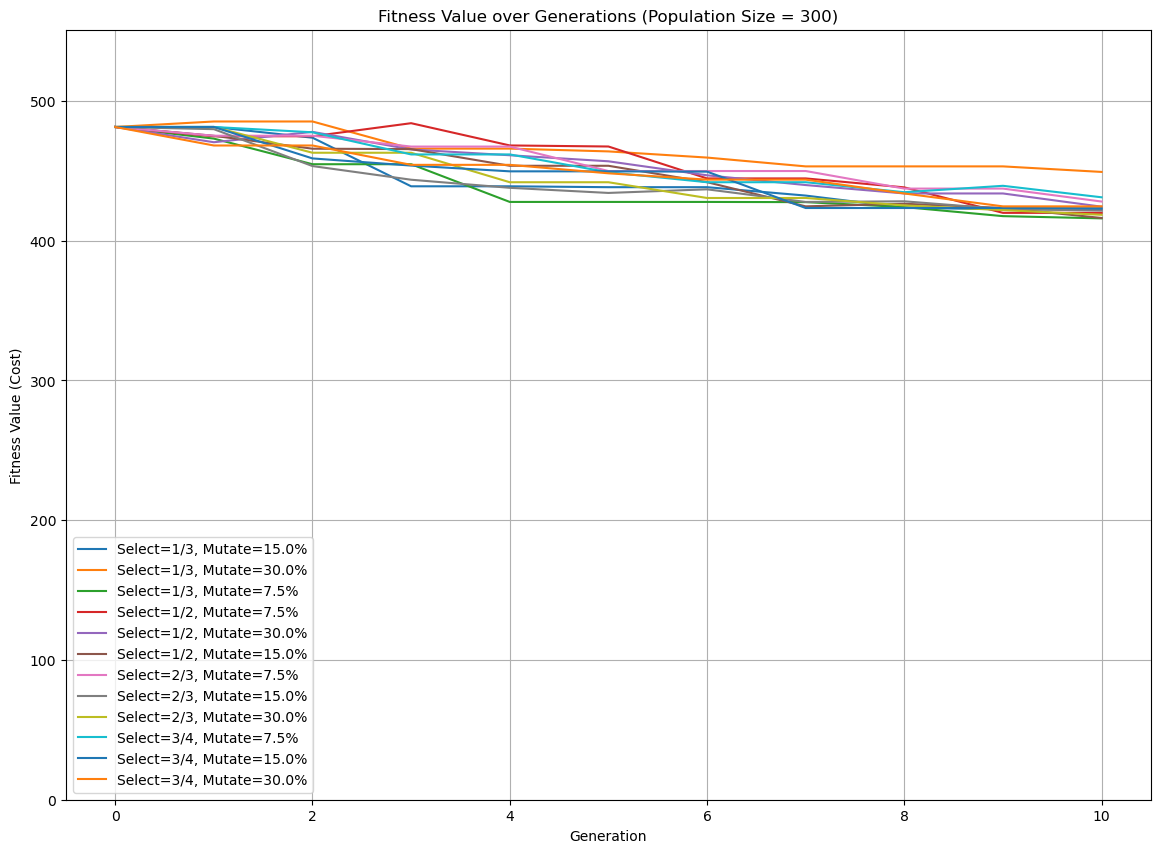

Final optimal fitness values for each combination:
Population Size: 75, Selection Ratio: 0.3333333333333333, Mutation Probability: 15.0% - Final Fitness: 463.1911798195832
Population Size: 75, Selection Ratio: 0.3333333333333333, Mutation Probability: 7.5% - Final Fitness: 480.1004168386138
Population Size: 75, Selection Ratio: 0.3333333333333333, Mutation Probability: 30.0% - Final Fitness: 496.29497381600845
Population Size: 75, Selection Ratio: 0.5, Mutation Probability: 7.5% - Final Fitness: 444.66566903348325
Population Size: 75, Selection Ratio: 0.5, Mutation Probability: 30.0% - Final Fitness: 466.25964397109396
Population Size: 75, Selection Ratio: 0.5, Mutation Probability: 15.0% - Final Fitness: 440.7596010014806
Population Size: 75, Selection Ratio: 0.6666666666666666, Mutation Probability: 7.5% - Final Fitness: 463.8980191912234
Population Size: 75, Selection Ratio: 0.6666666666666666, Mutation Probability: 15.0% - Final Fitness: 440.43464654756724
Population Size: 75, Sele

In [3]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import pickle  # 用于保存和读取文件
import os

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2

# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 保存初始种群
def save_population(population, filename):
    with open(filename, 'wb') as f:
        pickle.dump(population, f)

# 读取初始种群
def load_population(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 1000  # 设定总迭代次数
    cxpb = 0.5  # 交叉概率

    # 使用固定的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

        # 更新进度条
        pbar.update(1)

        # 更新Hall of Fame
        hof.update(pop)

    # 返回最终的最优结果
    return logbook, hof[0].fitness.values[0]

# 配置参数
population_sizes = [75, 150, 300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.075, 0.15, 0.3]

# 初始化进度条
progress_bars = {
    pop_size: tqdm(total=12 * 1000, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 用于存储所有图表的最小和最大适应度值，用于后续统一设置y轴范围
all_min_values = []
all_max_values = []
initial_fitness_values = {}  # 用于存储初始适应度值
final_results = {}  # 用于存储每种情况下的最终最优结果

# 逐个运行每个种群大小的12种情况
for population_size in population_sizes:
    population_filename = f"./output_TPE/initial_population_{filename1}_{population_size}.pkl"

    # 检查是否已有保存的初始种群文件
    if os.path.exists(population_filename):
        initial_population = load_population(population_filename)
    else:
        # 生成并保存初始种群
        initial_population = toolbox.population(n=population_size)
        save_population(initial_population, population_filename)

    # 评估初始种群的适应度
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]  # 记录最小适应度
    initial_fitness_values[population_size] = initial_fitness

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size]): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        logbooks = {}
        labels = {}

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, final_fitness = future.result()  # 获取最终的最优适应度值
                logbooks[(selection_ratio, mutpb)] = logbook
                ratio_fraction = Fraction(selection_ratio).limit_denominator()
                labels[(selection_ratio, mutpb)] = f'Select={ratio_fraction}, Mutate={mutpb * 100}%'

                # 更新最小和最大适应度值
                min_fitness_values = logbook.select("min")
                all_min_values.append(min(min_fitness_values))
                all_max_values.append(max(min_fitness_values))

                # 保存最终的最优结果
                final_results[(population_size, selection_ratio, mutpb)] = final_fitness

            except Exception as ex:
                print(
                    f'Error with population_size={population_size}, selection_ratio={selection_ratio}, mutpb={mutpb}: {ex}')

# 确定统一的y轴范围
y_min = 0
y_max = max(all_max_values)

# 重新绘制图表，确保y轴范围一致，并添加初始适应度值作为x=0点
for population_size in population_sizes:
    plt.figure(figsize=(14, 10))
    for (selection_ratio, mutpb), logbook in logbooks.items():
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness_values[population_size]] + min_fitness_values  # 添加初始适应度值
        generations = [0] + generations  # x轴从0开始

        plt.plot(generations, fitness_values, label=labels[(selection_ratio, mutpb)])

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output_TPE/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()

# 完成后关闭所有进度条
for pbar in progress_bars.values():
    pbar.close()

# 打印36种情况下的最终最优结果
print("Final optimal fitness values for each combination:")
for key, value in final_results.items():
    pop_size, select_ratio, mutate_prob = key
    print(f"Population Size: {pop_size}, Selection Ratio: {select_ratio}, Mutation Probability: {mutate_prob * 100}% - Final Fitness: {value}")



(ipykernel_launcher.py:22768): Gtk-WARNING **: 16:15:29.852: Locale not supported by C library.
	Using the fallback 'C' locale.


nodes:  25 links  57


Population=75:   0%|          | 0/12000 [00:00<?, ?it/s]

Population=150:   0%|          | 0/12000 [00:00<?, ?it/s]

Population=300:   0%|          | 0/12000 [00:00<?, ?it/s]

/home/huang/anaconda3/envs/gt/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


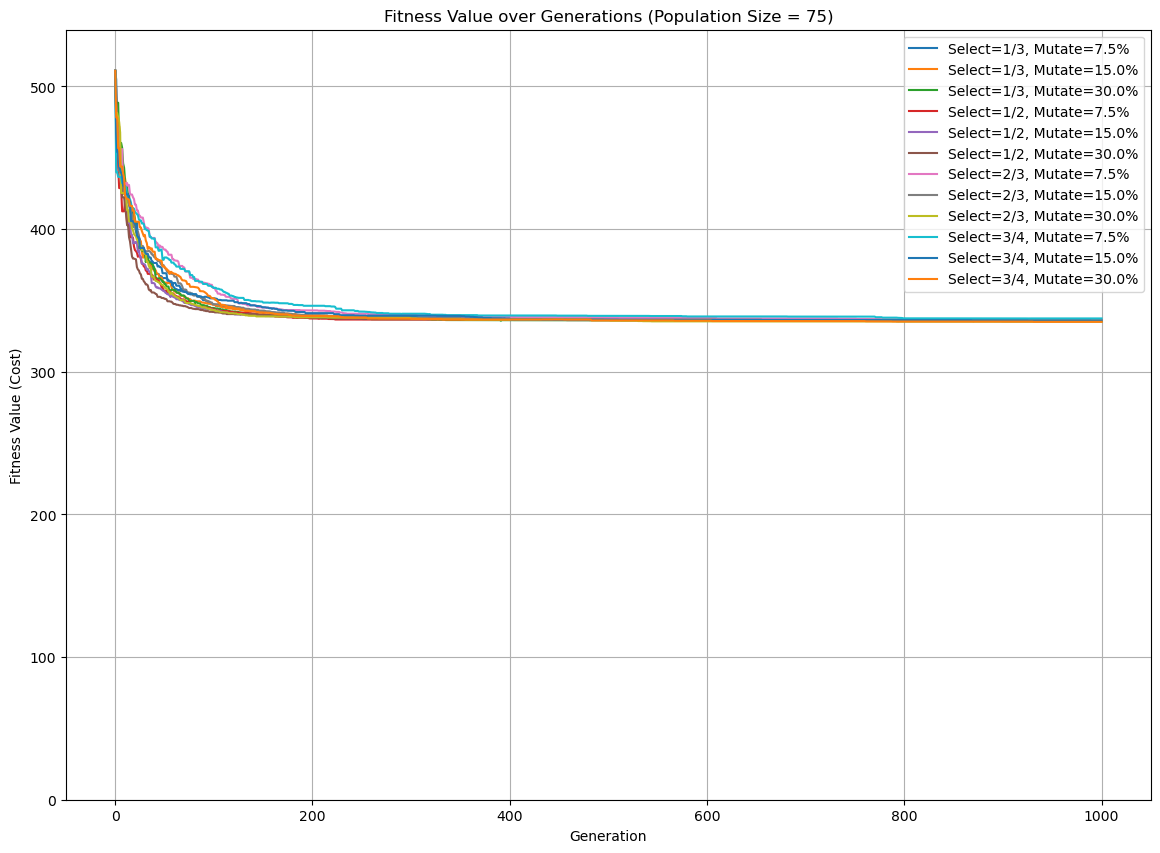

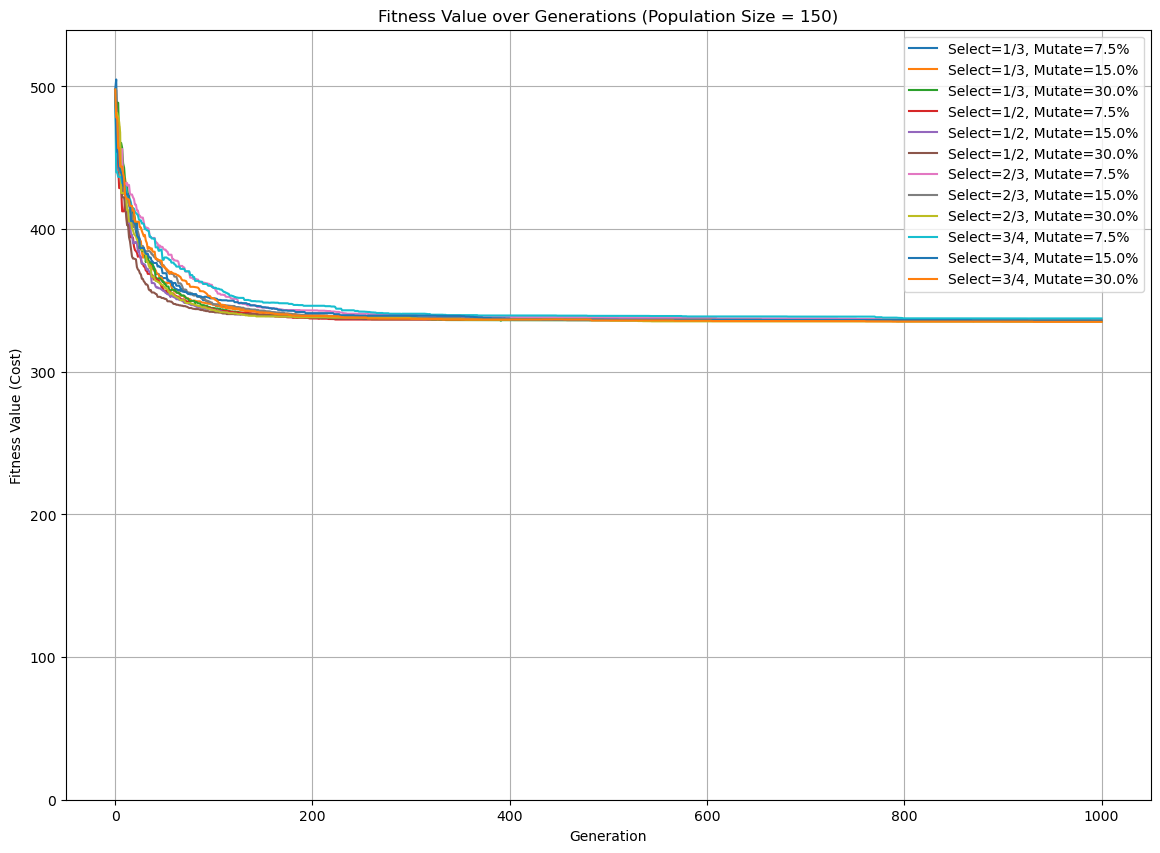

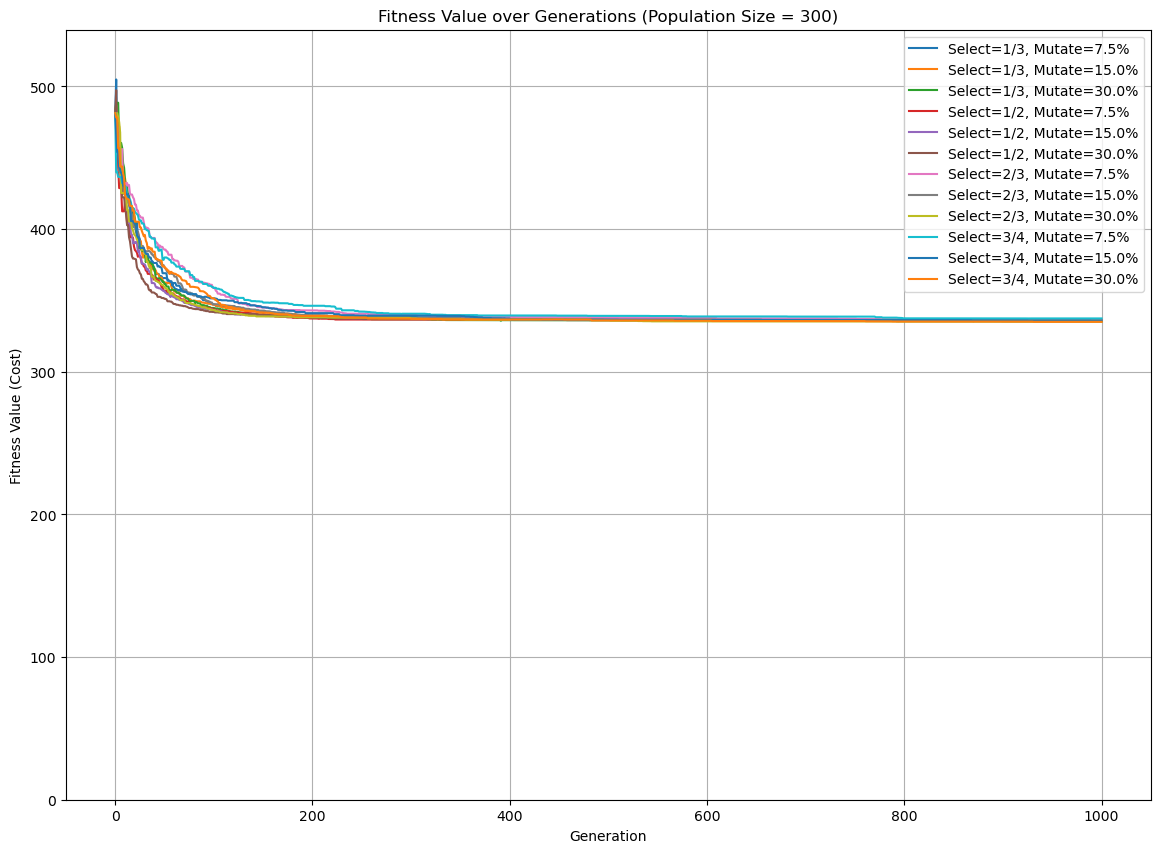

Final optimal fitness values for each combination:
Population Size: 75, Selection Ratio: 0.3333333333333333, Mutation Probability: 7.5% - Final Fitness: 338.81246162898935
Population Size: 75, Selection Ratio: 0.3333333333333333, Mutation Probability: 30.0% - Final Fitness: 336.0378359091354
Population Size: 75, Selection Ratio: 0.3333333333333333, Mutation Probability: 15.0% - Final Fitness: 337.39131774402824
Population Size: 75, Selection Ratio: 0.5, Mutation Probability: 7.5% - Final Fitness: 337.81023772562776
Population Size: 75, Selection Ratio: 0.5, Mutation Probability: 15.0% - Final Fitness: 337.20107344115695
Population Size: 75, Selection Ratio: 0.5, Mutation Probability: 30.0% - Final Fitness: 335.452591910462
Population Size: 75, Selection Ratio: 0.6666666666666666, Mutation Probability: 7.5% - Final Fitness: 338.8821907481604
Population Size: 75, Selection Ratio: 0.6666666666666666, Mutation Probability: 15.0% - Final Fitness: 337.94342570427887
Population Size: 75, Sele

In [1]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import pickle  # 用于保存和读取文件
import os

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 保存初始种群
def save_population(population, filename):
    with open(filename, 'wb') as f:
        pickle.dump(population, f)


# 读取初始种群
def load_population(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 1000  # 设定总迭代次数
    cxpb = 0.5  # 交叉概率

    # 使用固定的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

        # 更新进度条
        pbar.update(1)

        # 更新Hall of Fame
        hof.update(pop)

    # 返回最终的最优结果
    return logbook, hof[0].fitness.values[0]


# 配置参数
population_sizes = [75, 150, 300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.075, 0.15, 0.3]

# 初始化进度条
progress_bars = {
    pop_size: tqdm(total=12 * 1000, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 用于存储所有图表的最小和最大适应度值，用于后续统一设置y轴范围
all_min_values = []
all_max_values = []
initial_fitness_values = {}  # 用于存储初始适应度值
final_results = {}  # 用于存储每种情况下的最终最优结果

# 逐个运行每个种群大小的12种情况
for population_size in population_sizes:
    population_filename = f"./output_TPE/initial_population_{filename1}_{population_size}.pkl"

    # 检查是否已有保存的初始种群文件
    if os.path.exists(population_filename):
        initial_population = load_population(population_filename)
    else:
        # 生成并保存初始种群
        initial_population = toolbox.population(n=population_size)
        save_population(initial_population, population_filename)

    # 评估初始种群的适应度
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]  # 记录最小适应度
    initial_fitness_values[population_size] = initial_fitness

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size]): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        logbooks = {}
        labels = {}

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, final_fitness = future.result()  # 获取最终的最优适应度值
                logbooks[(selection_ratio, mutpb)] = logbook
                ratio_fraction = Fraction(selection_ratio).limit_denominator()
                labels[(selection_ratio, mutpb)] = f'Select={ratio_fraction}, Mutate={mutpb * 100}%'

                # 更新最小和最大适应度值
                min_fitness_values = logbook.select("min")
                all_min_values.append(min(min_fitness_values))
                all_max_values.append(max(min_fitness_values))

                # 保存最终的最优结果
                final_results[(population_size, selection_ratio, mutpb)] = final_fitness

            except Exception as ex:
                print(
                    f'Error with population_size={population_size}, selection_ratio={selection_ratio}, mutpb={mutpb}: {ex}')

# 确定统一的y轴范围
y_min = 0
y_max = max(all_max_values)

# 重新绘制图表，确保y轴范围一致，并添加初始适应度值作为x=0点
for population_size in population_sizes:
    plt.figure(figsize=(14, 10))
    for (selection_ratio, mutpb), logbook in logbooks.items():
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness_values[population_size]] + min_fitness_values  # 添加初始适应度值
        generations = [0] + generations  # x轴从0开始

        plt.plot(generations, fitness_values, label=labels[(selection_ratio, mutpb)])

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output_TPE/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()

# 完成后关闭所有进度条
for pbar in progress_bars.values():
    pbar.close()

# 打印36种情况下的最终最优结果
print("Final optimal fitness values for each combination:")
for key, value in final_results.items():
    pop_size, select_ratio, mutate_prob = key
    print(
        f"Population Size: {pop_size}, Selection Ratio: {select_ratio}, Mutation Probability: {mutate_prob * 100}% - Final Fitness: {value}")


nodes:  25 links  57


/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Population=75:   0%|          | 0/12000 [00:00<?, ?it/s]

Population=150:   0%|          | 0/12000 [00:00<?, ?it/s]

Population=300:   0%|          | 0/12000 [00:00<?, ?it/s]

Completed: Pop=75, Select=0.3333333333333333, Mutate=0.15 - Fitness=337.98412808045543
Completed: Pop=75, Select=0.3333333333333333, Mutate=0.075 - Fitness=339.90910491230085
Completed: Pop=75, Select=0.3333333333333333, Mutate=0.3 - Fitness=337.69704753638894
Completed: Pop=75, Select=0.5, Mutate=0.075 - Fitness=338.53301292993433
Completed: Pop=75, Select=0.5, Mutate=0.3 - Fitness=338.2460775580271
Completed: Pop=75, Select=0.5, Mutate=0.15 - Fitness=339.42520129218724
Completed: Pop=75, Select=0.6666666666666666, Mutate=0.075 - Fitness=339.3633075790907
Completed: Pop=75, Select=0.6666666666666666, Mutate=0.15 - Fitness=337.82429856070496
Completed: Pop=75, Select=0.6666666666666666, Mutate=0.3 - Fitness=336.8786593200323
Completed: Pop=75, Select=0.75, Mutate=0.075 - Fitness=343.33455510692073
Completed: Pop=75, Select=0.75, Mutate=0.15 - Fitness=338.92152028772387
Completed: Pop=75, Select=0.75, Mutate=0.3 - Fitness=336.75817467555134
Completed: Pop=150, Select=0.3333333333333333,

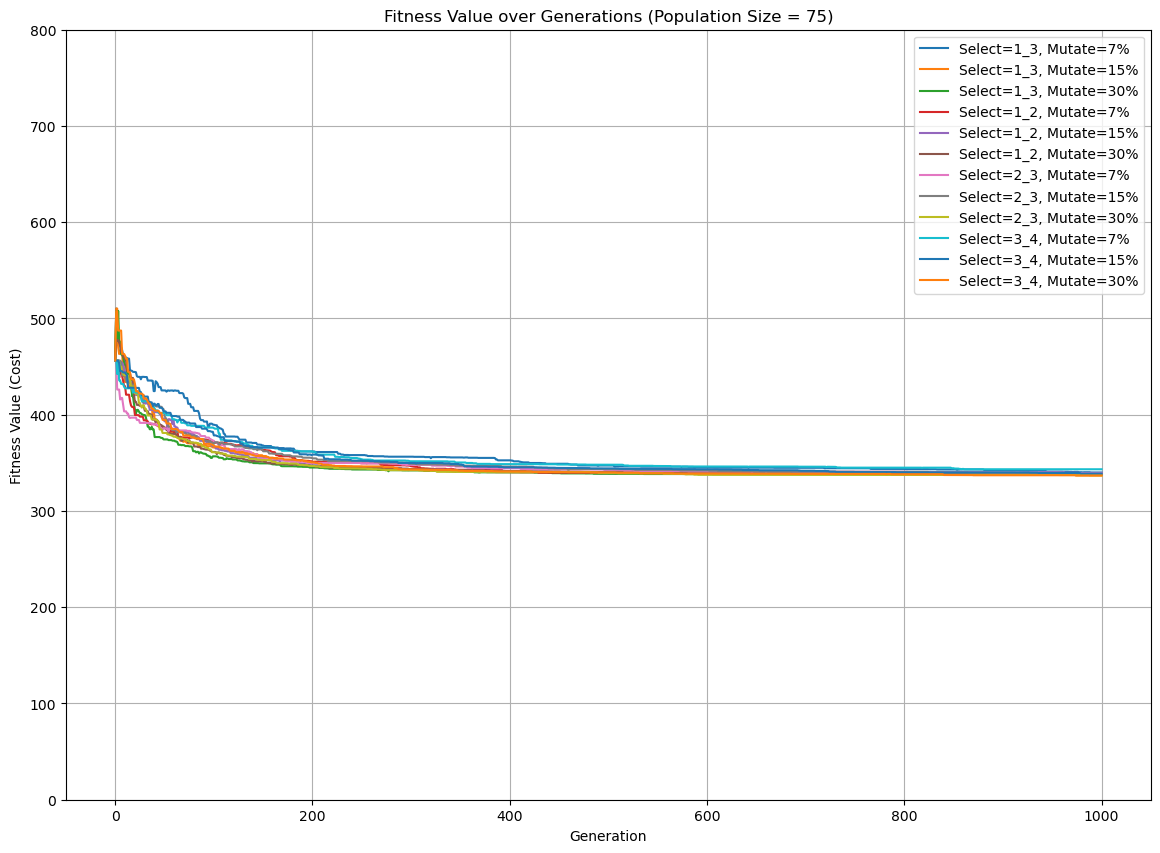

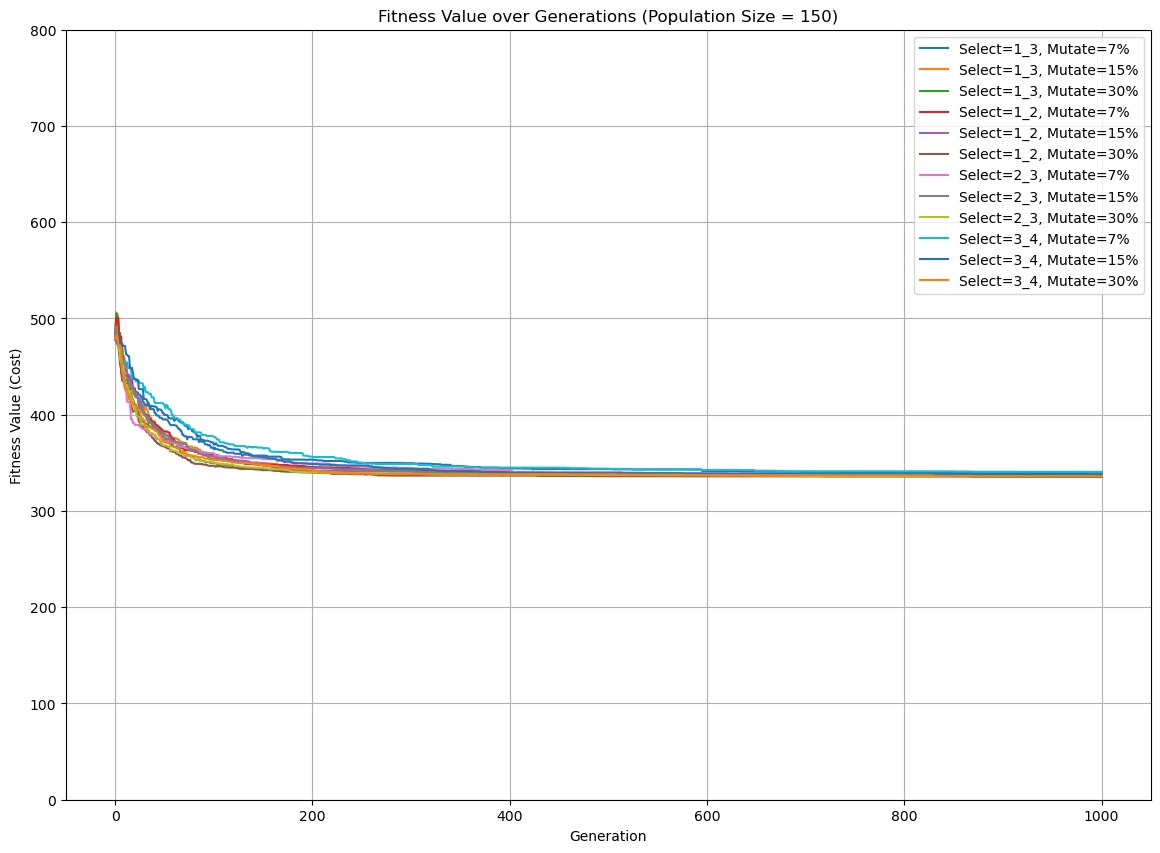

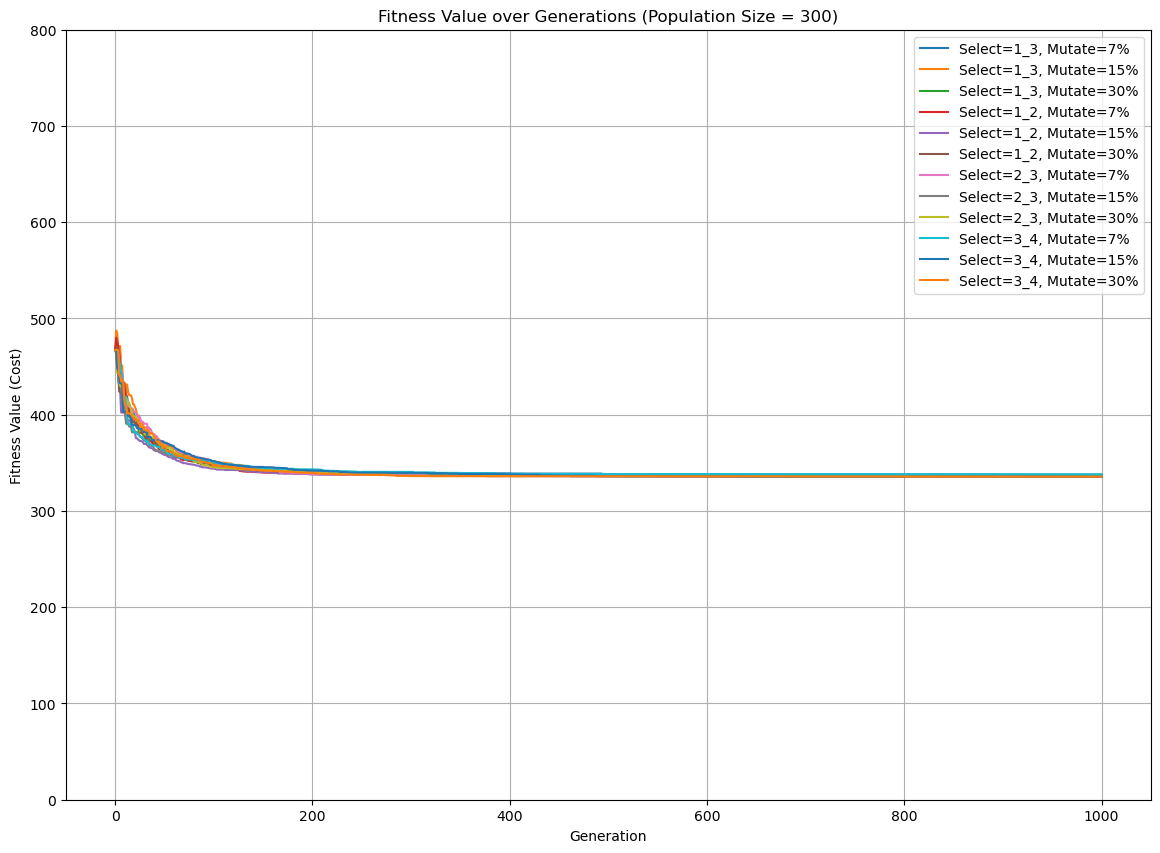

In [2]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import pickle
import os

# 读取图和位置信息
filename1 = "ATT_US_Norm" 
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 保存初始种群
def save_population(population, filename):
    with open(filename, 'wb') as f:
        pickle.dump(population, f)


# 读取初始种群
def load_population(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 保存遗传算法的迭代过程数据
def save_logbook(logbook, filename):
    with open(filename, 'wb') as f:
        pickle.dump(logbook, f)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar, logbook_filename):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 1000  # 设定总迭代次数
    cxpb = 0.5  # 交叉概率

    # 使用固定的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

        # 更新进度条
        pbar.update(1)

        # 更新Hall of Fame
        hof.update(pop)

    # 保存logbook到文件
    save_logbook(logbook, logbook_filename)

    return logbook, hof[0].fitness.values[0]


# 配置参数
population_sizes = [75, 150, 300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.075, 0.15, 0.3]

# 初始化进度条
progress_bars = {
    pop_size: tqdm(total=12 * 1000, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 逐个运行每个种群大小的12种情况，并保存过程数据
for population_size in population_sizes:
    population_filename = f"./output_36/initial_population_{filename1}_{population_size}.pkl"
    logbook_filenames = []

    # 检查是否已有保存的初始种群文件
    if os.path.exists(population_filename):
        initial_population = load_population(population_filename)
    else:
        # 生成并保存初始种群
        initial_population = toolbox.population(n=population_size)
        save_population(initial_population, population_filename)

    # 计算初始种群的适应度并存储作为初始点
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]  # 获取最小的适应度

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size],
                            f"./output_36/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                                "/", "_")): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            logbook_filename = f"./output_36/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
                "/", "_")
            logbook_filenames.append(logbook_filename)
            try:
                _, final_fitness = future.result()
                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Fitness={final_fitness}')
            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 完成后关闭所有进度条
for pbar in progress_bars.values():
    pbar.close()


# 读取并绘制图像
def load_logbook(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# 统一 y 轴范围为 0 到 3000
y_min = 0
y_max = 800


# 绘制图像
def plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness] + min_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0]
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%')

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output_36/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()


# 读取保存的logbook文件并生成图像
for population_size in population_sizes:
    logbook_filenames = [
        f"./output_36/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
            "/", "_")
        for selection_ratio in selection_ratios
        for mutpb in mutation_probs
    ]

    # 计算初始种群的适应度
    initial_population = load_population(f"./output_36/initial_population_{filename1}_{population_size}.pkl")
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness)


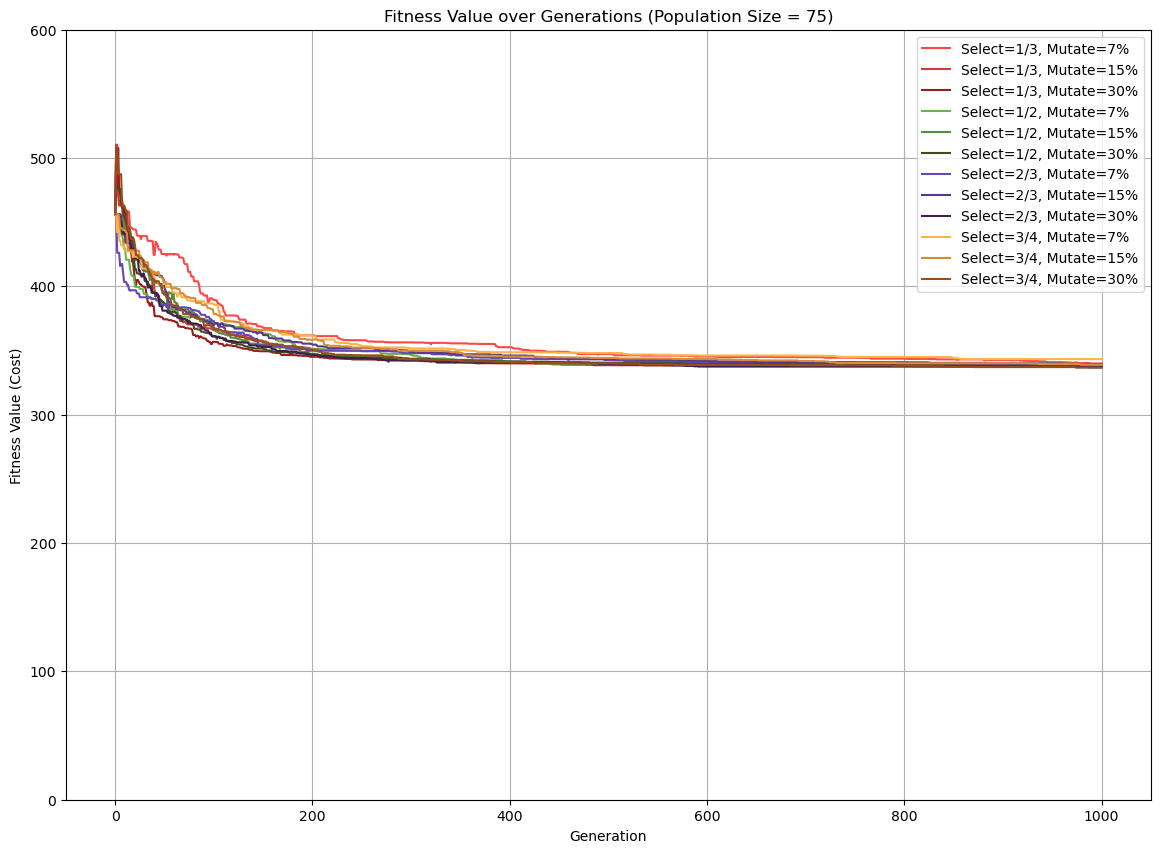

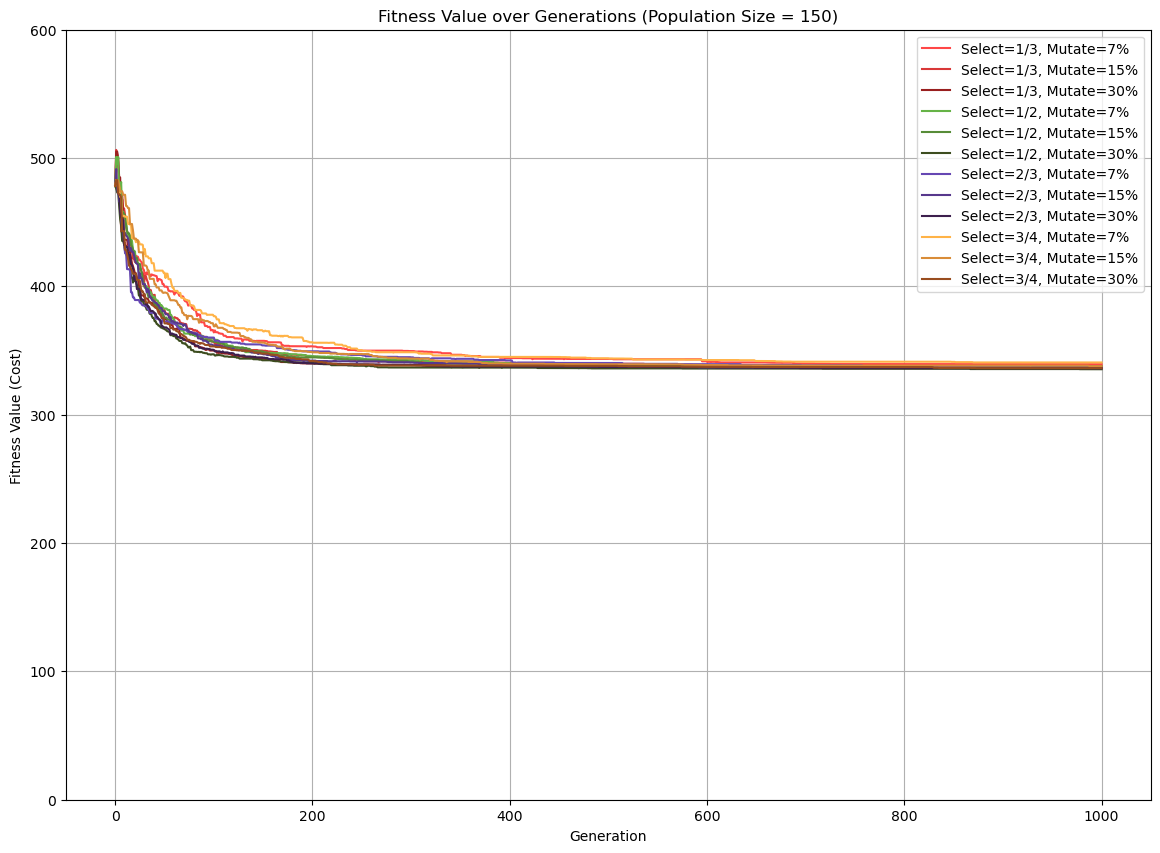

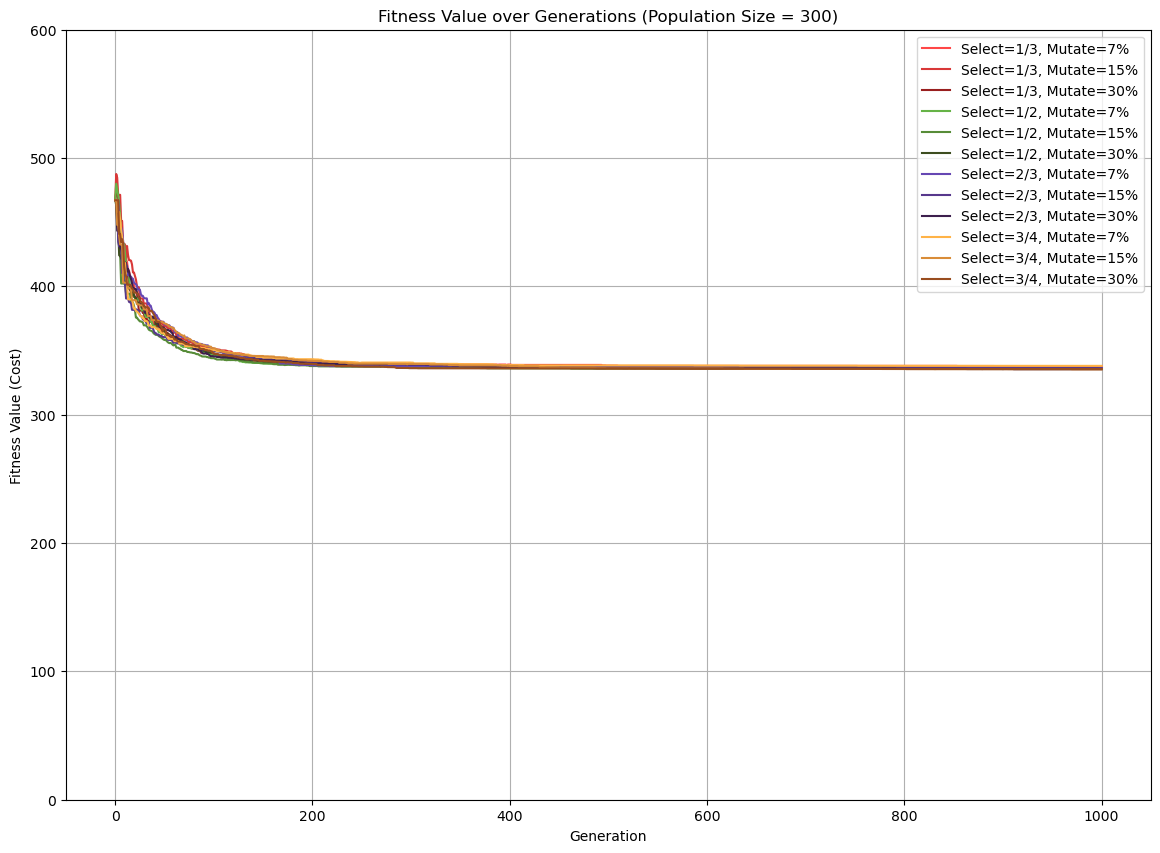

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from fractions import Fraction
from matplotlib.colors import LinearSegmentedColormap

# 读取并绘制图像
def load_logbook(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# 设置统一的y轴范围为0到600
y_min = 0
y_max = 600

# 为不同的Select值设置色调（Hue）
select_colors = {
    "1/3": (1.0, 0.4, 0.4),  # 红色调
    "1/2": (0.4, 1.0, 0.4),  # 绿色调
    "2/3": (0.4, 0.4, 1.0),  # 蓝色调
    "3/4": (1.0, 1.0, 0.4)   # 黄色调
}

# 为不同的Mutate值生成渐变色
def get_mutate_color(base_color, mutate_value):
    base_r, base_g, base_b = base_color
    if mutate_value == "7":
        return (base_r * 1.0, base_g * 0.7, base_b * 0.7)  # 浅色
    elif mutate_value == "15":
        return (base_r * 0.85, base_g * 0.55, base_b * 0.55)  # 中间色
    elif mutate_value == "30":
        return (base_r * 0.6, base_g * 0.3, base_b * 0.3)  # 深色

# 绘制图像
def plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness] + min_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0].replace("_", "/")
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        # 根据Select和Mutate来设置颜色
        base_color = select_colors[select_info]
        line_color = get_mutate_color(base_color, mutate_info)

        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%', color=line_color)

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output_36/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()

# 读取保存的logbook文件并生成图像
for population_size in [75, 150, 300]:
    logbook_filenames = [
        f"./output_36/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
            "/", "_")
        for selection_ratio in [1 / 3, 1 / 2, 2 / 3, 3 / 4]
        for mutpb in [0.075, 0.15, 0.3]
    ]

    # 读取初始种群的适应度
    initial_population = load_population(f"./output_36/initial_population_{filename1}_{population_size}.pkl")
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness)


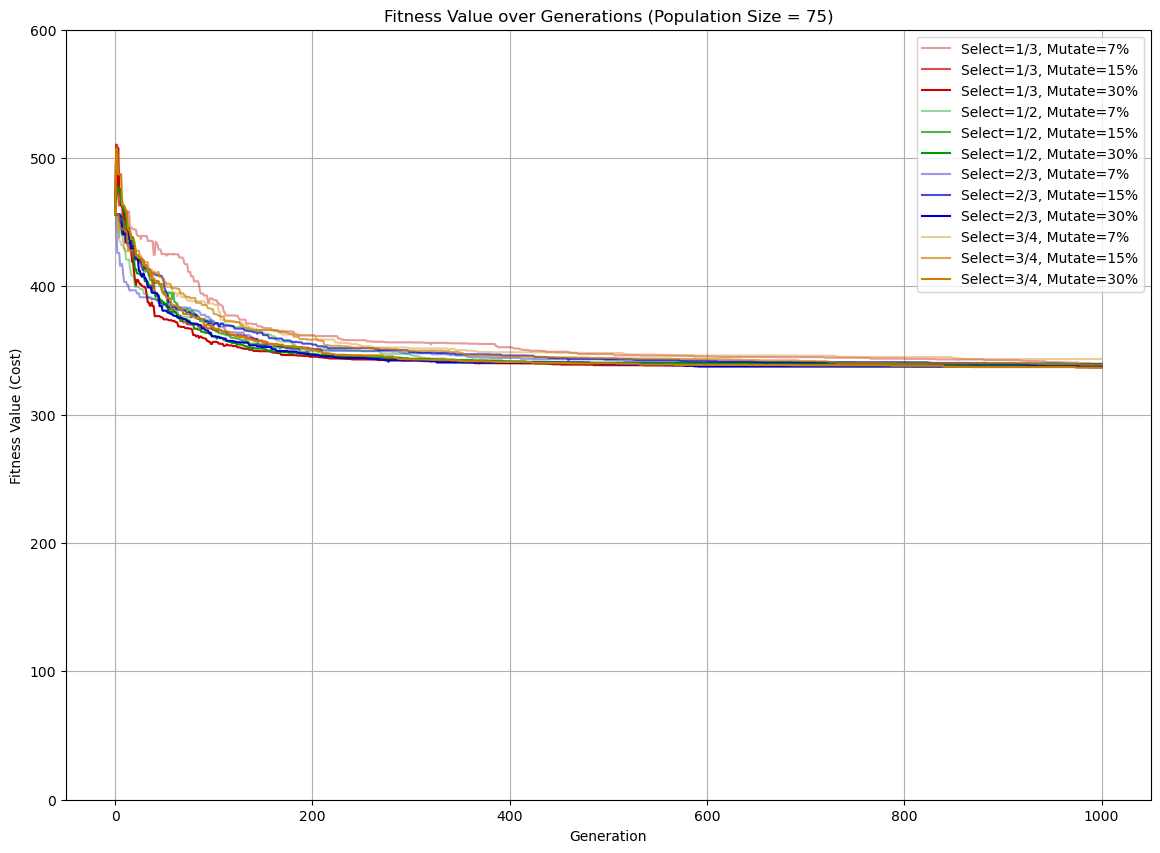

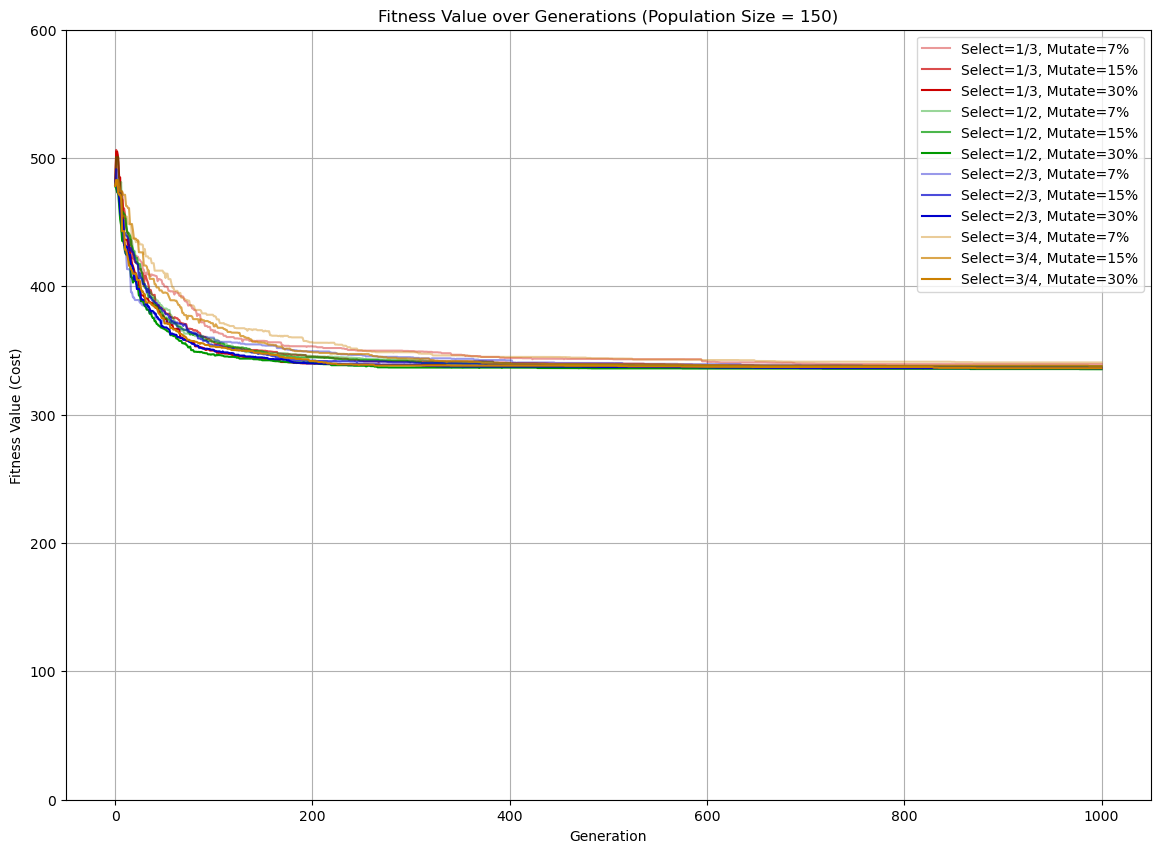

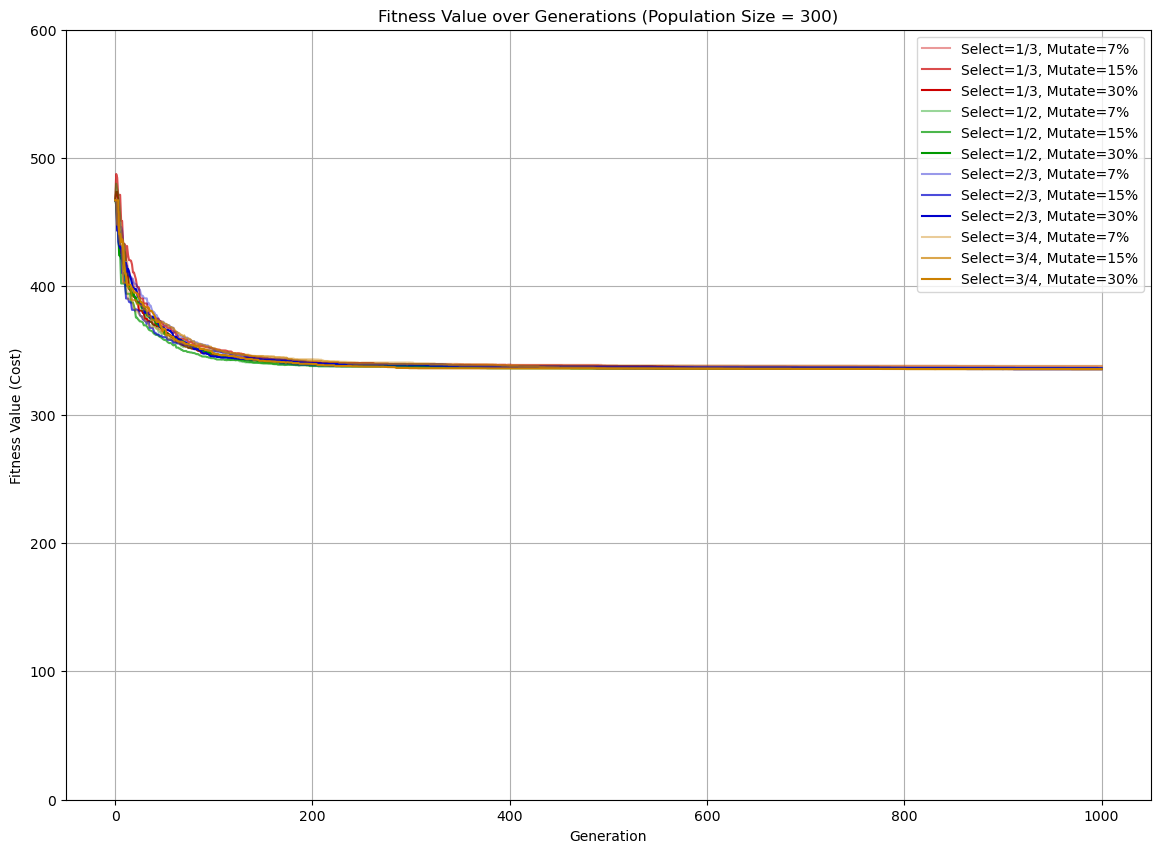

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from fractions import Fraction

# 读取并绘制图像
def load_logbook(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# 设置统一的y轴范围为0到600
y_min = 0
y_max = 600

# 为不同的Select值设置显著不同的颜色
select_colors = {
    "1/3": (0.8, 0.0, 0.0),  # 红色
    "1/2": (0.0, 0.6, 0.0),  # 绿色
    "2/3": (0.0, 0.0, 0.8),  # 蓝色
    "3/4": (0.8, 0.5, 0.0)   # 橙色
}

# 为不同的Mutate值调整颜色的亮度或透明度
def get_mutate_color(base_color, mutate_value):
    base_r, base_g, base_b = base_color
    if mutate_value == "7":
        return (base_r, base_g, base_b, 0.4)  # 最浅，透明度高
    elif mutate_value == "15":
        return (base_r, base_g, base_b, 0.7)  # 中间透明度
    elif mutate_value == "30":
        return (base_r, base_g, base_b, 1.0)  # 最深，透明度低

# 绘制图像
def plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness] + min_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0].replace("_", "/")
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        # 根据Select和Mutate来设置颜色
        base_color = select_colors[select_info]
        line_color = get_mutate_color(base_color, mutate_info)

        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%', color=line_color)

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output_36/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()

# 读取保存的logbook文件并生成图像
for population_size in [75, 150, 300]:
    logbook_filenames = [
        f"./output_36/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
            "/", "_")
        for selection_ratio in [1 / 3, 1 / 2, 2 / 3, 3 / 4]
        for mutpb in [0.075, 0.15, 0.3]
    ]

    # 读取初始种群的适应度
    initial_population = load_population(f"./output_36/initial_population_{filename1}_{population_size}.pkl")
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness)


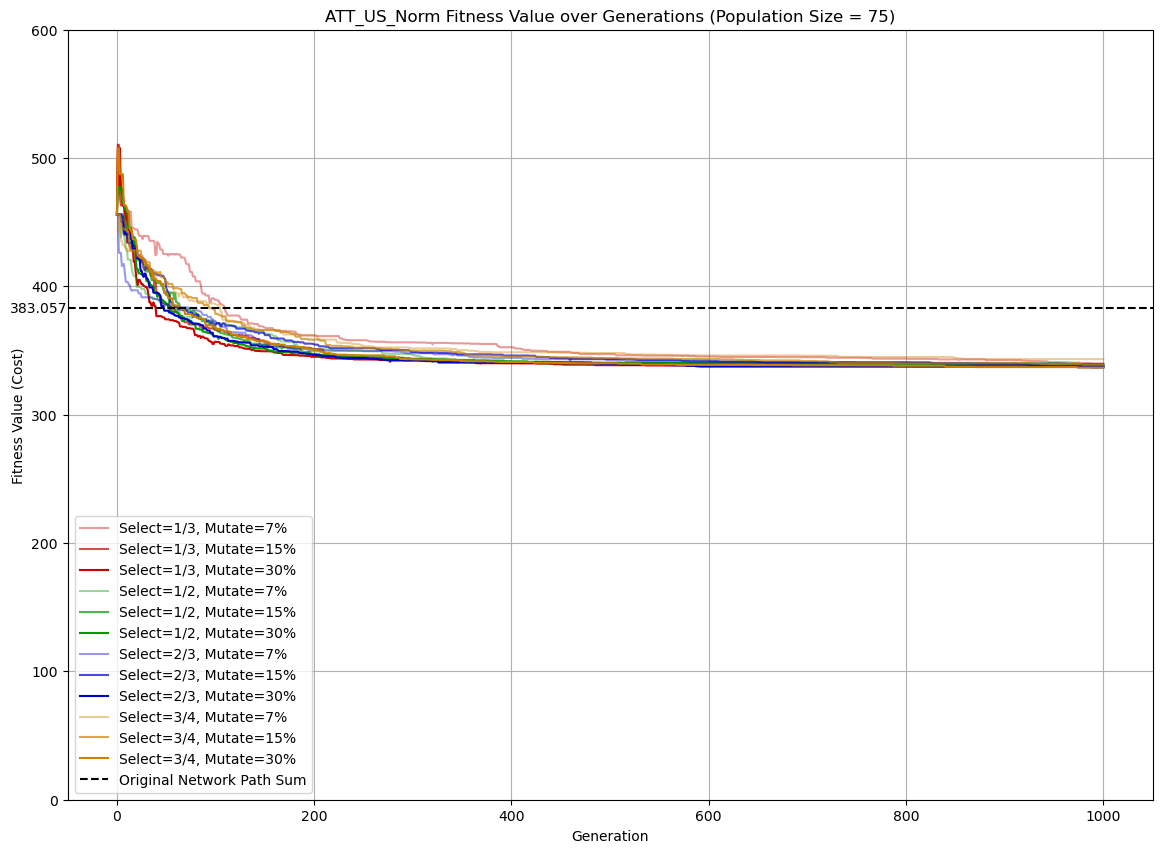

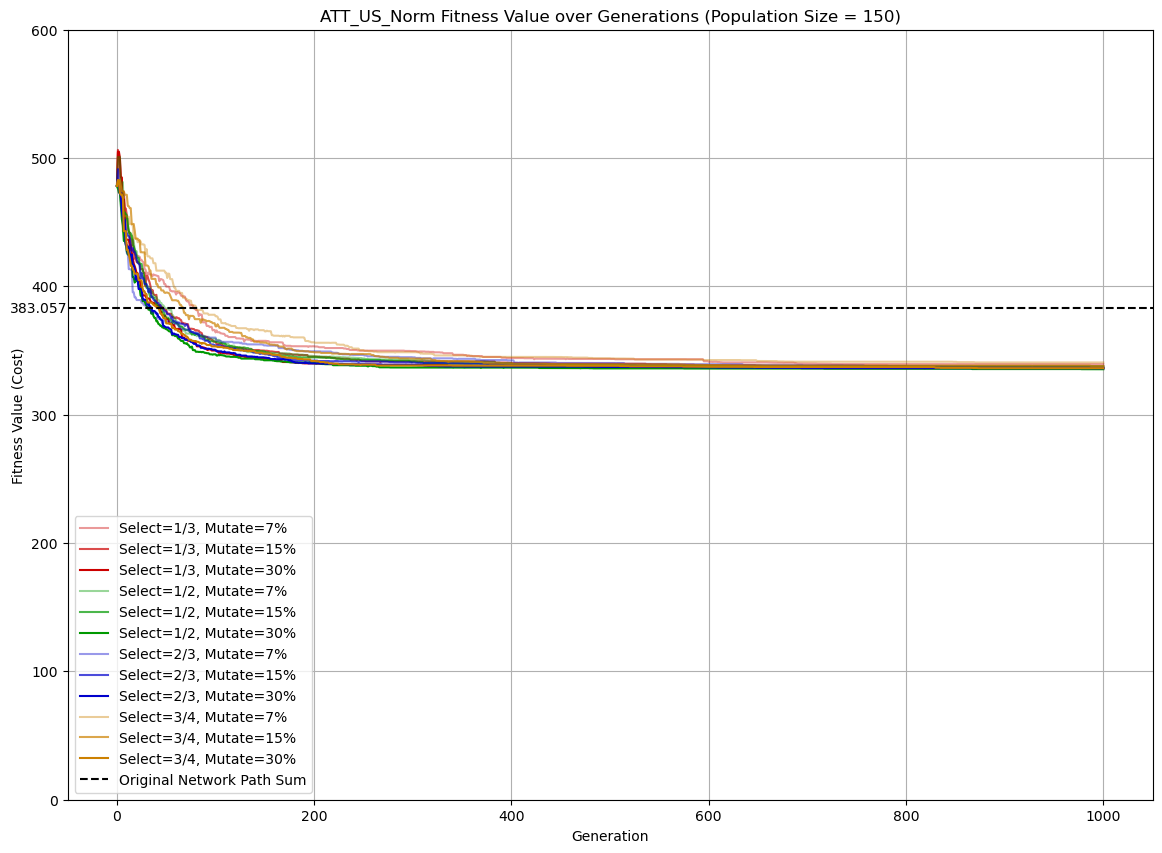

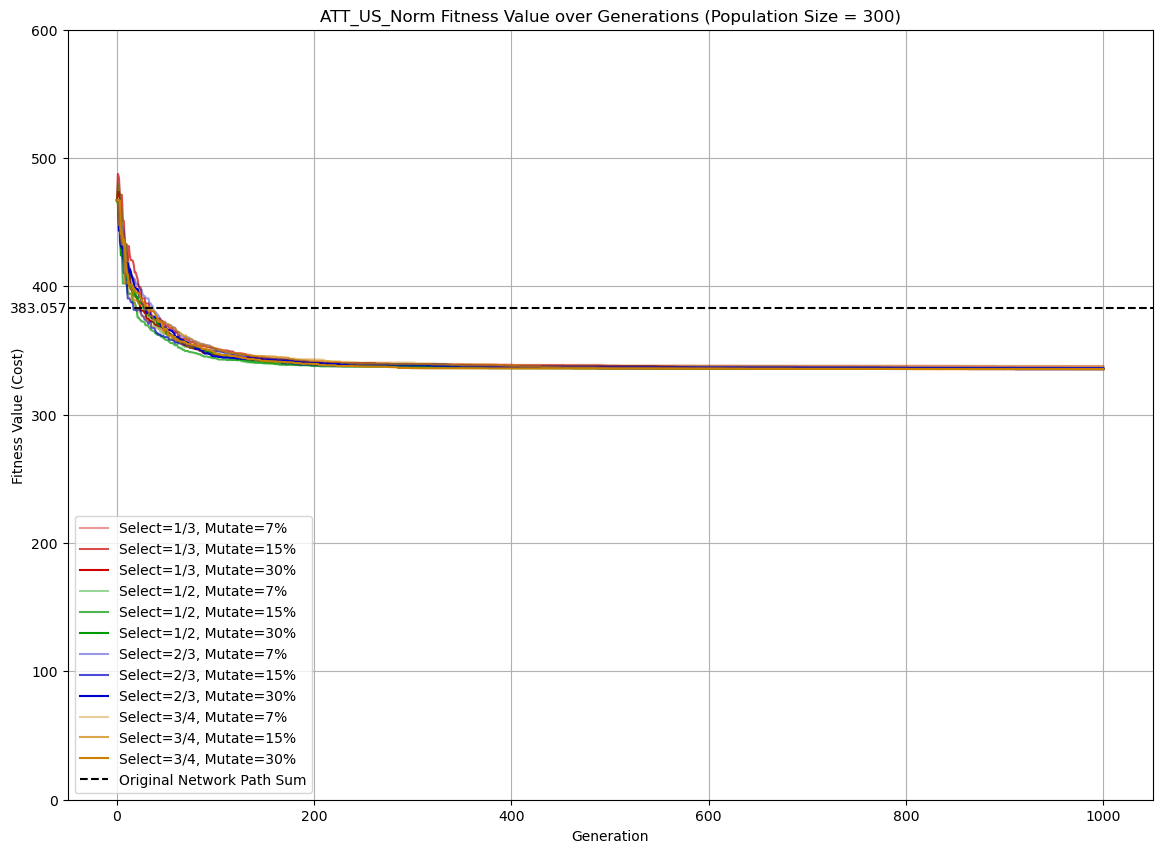

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from fractions import Fraction

# 读取并绘制图像
def load_logbook(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# 设置统一的y轴范围为0到600
y_min = 0
y_max = 600

# 原始网络的路径和
original_network_path_sum = 383.057

# 为不同的Select值设置显著不同的颜色
select_colors = {
    "1/3": (0.8, 0.0, 0.0),  # 红色
    "1/2": (0.0, 0.6, 0.0),  # 绿色
    "2/3": (0.0, 0.0, 0.8),  # 蓝色
    "3/4": (0.8, 0.5, 0.0)   # 橙色
}

# 为不同的Mutate值调整颜色的亮度或透明度
def get_mutate_color(base_color, mutate_value):
    base_r, base_g, base_b = base_color
    if mutate_value == "7":
        return (base_r, base_g, base_b, 0.4)  # 最浅，透明度高
    elif mutate_value == "15":
        return (base_r, base_g, base_b, 0.7)  # 中间透明度
    elif mutate_value == "30":
        return (base_r, base_g, base_b, 1.0)  # 最深，透明度低

# 绘制图像
def plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness):
    plt.figure(figsize=(14, 10))
    for filename in logbook_filenames:
        logbook = load_logbook(filename)
        min_fitness_values = logbook.select("min")
        generations = list(range(1, len(min_fitness_values) + 1))
        fitness_values = [initial_fitness] + min_fitness_values  # 添加初始适应度值作为第一个点
        generations = [0] + generations  # 确保x轴从0开始

        # 获取选择率和变异率的信息来作为标签
        select_info = filename.split("_sel")[1].split("_mut")[0].replace("_", "/")
        mutate_info = filename.split("_mut")[1].split(".pkl")[0]

        # 根据Select和Mutate来设置颜色
        base_color = select_colors[select_info]
        line_color = get_mutate_color(base_color, mutate_info)

        plt.plot(generations, fitness_values, label=f'Select={select_info}, Mutate={mutate_info}%', color=line_color)

    # 添加y=383.057的y轴标注
    plt.axhline(y=original_network_path_sum, color='black', linestyle='--', label='Original Network Path Sum')
    plt.text(-50, original_network_path_sum, f'{original_network_path_sum}', va='center', ha='right', color='black')

    plt.title(f"{filename1} Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 设置统一的y轴范围
    plt.ylim(y_min, y_max)

    # 保存图表
    plt.savefig(f"./output_36/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()

# 读取保存的logbook文件并生成图像
for population_size in [75, 150, 300]:
    logbook_filenames = [
        f"./output_36/logbook_{filename1}_pop{population_size}_sel{Fraction(selection_ratio).limit_denominator()}_mut{int(mutpb * 100)}.pkl".replace(
            "/", "_")
        for selection_ratio in [1 / 3, 1 / 2, 2 / 3, 3 / 4]
        for mutpb in [0.075, 0.15, 0.3]
    ]

    # 读取初始种群的适应度
    initial_population = load_population(f"./output_36/initial_population_{filename1}_{population_size}.pkl")
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    plot_fitness_over_generations(logbook_filenames, population_size, y_min, y_max, initial_fitness)
